파인튜닝 - MobileNet <br>
모델 전체 (또는 대부분의  layer) 대한 가중치 학습(조정)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 학습, 검증, 테스트 데이터셋의 경로를 설정
TRAIN_DATA_DIR = '/content/drive/MyDrive/CNN/m.s_train/'
VALIDATION_DATA_DIR = '/content/drive/MyDrive/CNN/m.s_val/'
TEST_DATA_DIR = '/content/drive/MyDrive/CNN/m.s_test/'

# 학습, 검증, 분류할 클래스, 이미지 크기, 배치 크기 설정
TRAIN_SAMPLES = 200*2
VALIDATION_SAMPLES = 10*2
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224 # image size for MobileNet
BATCH_SIZE = 2 # 64

ImageDataGenerator 클래스를 사용해서 data augmentation <br>
학습데이터 augmentation<br>
(평가데이터, 검증데이터는 증강 x)

In [ ]:
# 학습 데이터에 대해서는 데이터 증강 적용 -> 모델의 일반화 성능 향상
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, # 입력 포맷팅, normalization(픽셀 값 조정)
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2, # 최대 20%까지 무작위 확대
                                   horizontal_flip=True,
                                   vertical_flip=True)

# 검증 데이터에는 증강 적용 X
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  # 다른 옵션 없음, 증대 변환을 적용 X -> 실제 검증 환경의 예상 형식 및 분포와 최대한 유사하게 데이터에 대한 모델 평가


In [ ]:
# 학습 및 검증 데이터 제너레이터를 설정
# train_datagen을 사용해서 학습 데이터 호출, 모델에 제공
# data augmentation -> 이미지 배치가 에포크마다 모델에 공급
# train_generator는 학습 동안 모델에 데이터를 제공하는 역할을 합니다. train_datagen에 의해 지정된 데이터 증강과

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, # 학습 이미지가 저장된 디렉토리의 경로입니다. 이 경로 내의 폴더 구조는 각 클래스별로 분류되어 있어야 하며, 각 클래스 폴더 내에 해당 클래스의 이미지들이 들어 있습니다.
                                                    target_size=(IMG_WIDTH,  # 모델에 입력될 이미지의 크기 설정, MobileNet 224x224
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345, # 데이터 randomness...
                                                    class_mode='categorical') # 레이블을 원-핫 인코딩 형태로 변환


Found 409 images belonging to 2 classes.


In [ ]:
# val_datagen을 이용해서 검증 데이터를 불러옴
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 20 images belonging to 2 classes.


In [ ]:
model = MobileNet()

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
model1 = MobileNet(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
 # include_top=False: 모델의 top layer(분류 레이어) 포함 X
 # input_shape=(IMG_WIDTH, IMG_HEIGHT, 3): 입력 이미지의 형태 지정, 3 : 컬러 이미지 채널 수(RGB)




17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
model1.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

새로운 모형 구축

In [ ]:
# Functional
# MobileNet을 기반으로 사용자 정의 모델 구축
# 모든 레이어의 학습 가능 여부를 False로 설정 -< 가중치를 고정
def model_maker():
    # top 층을 제외한 사전학습 모형 호출
    base_model = MobileNet(include_top=False,
                           input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    for layer in base_model.layers[:]:
        layer.trainable = False # 학습 과정에서 이 레이어들의 가중치 업데이트 X -> 학습된 가중치 값 유지
        # 각 layer의 학습 여부 결정 => 기본값 True
        # 모형의 구조만 변경, 파라미터는 새롭게 학습 X

    # Input 클래스를 이용해서 입력 데이터의 형태를 지정
    input1 = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model) # 각 채널 (7x7 채널)에서 평균값 하나만 추출
        # 기본 네트워크의 출력 feature 맵의 차원(높이 및 너비)을  줄임
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)
        # 출력 층, NUM_CLASSES : 예측 클래스 수 = 2
    return Model(inputs=input1, outputs=predictions)

In [ ]:
model_final = model_maker()


In [ ]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3294594 (12.57 MB)
Trainable params: 65730 (2

In [ ]:
# 손실 함수, 최적화 알고리즘, 평가 지표 설정
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])


In [ ]:
# 모델을 컴파일, 학습 수행
history = model_final.fit(
    train_generator, # 학습데이터 호출
    steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates, 1 epoch 당 업데이트 횟수 지정
    epochs=5, # 20,
    validation_data=validation_generator, # 검증 데이터 호출
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE)
      # ImageDataGenerator가 각 batch마다 random하게 BATCH_SIZE (=64)에 해당하는 이미지 생성

Epoch 1/5
157/200 [======================>.......] - ETA: 45s - loss: 0.6956 - acc: 0.7029

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (109542160 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


200/200 [==============================] - 220s 1s/step - loss: 0.6432 - acc: 0.7193 - val_loss: 0.1859 - val_acc: 0.9500
Epoch 2/5
200/200 [==============================] - 76s 381ms/step - loss: 0.4760 - acc: 0.7895 - val_loss: 0.2708 - val_acc: 0.8500
Epoch 3/5
200/200 [==============================] - 76s 381ms/step - loss: 0.3750 - acc: 0.8446 - val_loss: 0.1535 - val_acc: 0.9500
Epoch 4/5
200/200 [==============================] - 72s 355ms/step - loss: 0.3644 - acc: 0.8521 - val_loss: 0.0672 - val_acc: 1.0000
Epoch 5/5
200/200 [==============================] - 73s 366ms/step - loss: 0.2876 - acc: 0.8847 - val_loss: 0.1932 - val_acc: 0.9000


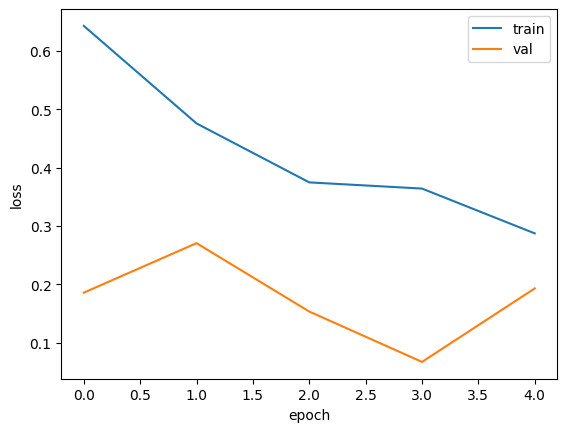

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

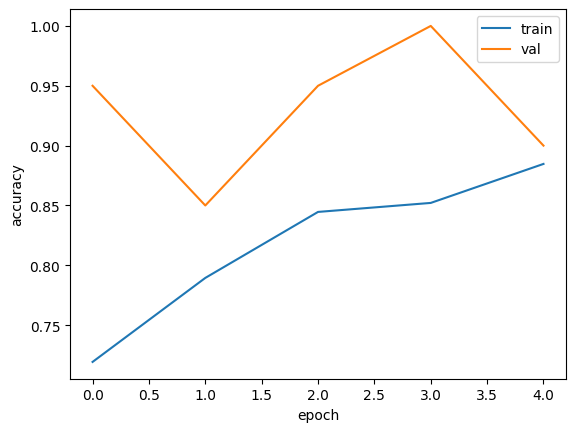

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 20 images belonging to 2 classes.


In [ ]:
model_final.evaluate(test_generator, steps=800 // BATCH_SIZE,verbose=1)

 10/400 [..............................] - ETA: 7:03 - loss: 0.0707 - acc: 0.9500

400/400 [==============================] - 10s 25ms/step - loss: 0.0707 - acc: 0.9500


[0.0707053691148758, 0.949999988079071]

In [ ]:
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

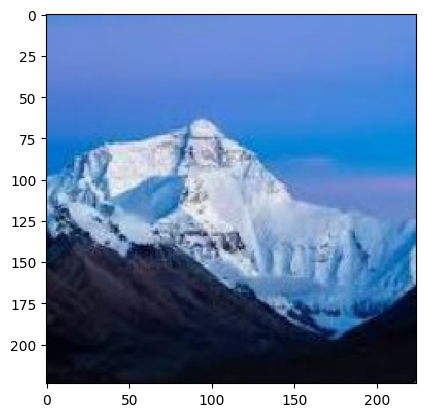

In [ ]:
img_path = '/content/mm.JPG'
# img_path = '/content/ss.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
plt.imshow(img_array/255)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = expanded_img_array / 255

In [ ]:
prediction = model_final.predict(preprocessed_img)
print(np.array(prediction[0]))

1/1 [==============================] - 0s 52ms/step
[0.9994547  0.00054528]


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def model_maker():
    base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the layers

    input1 = Input(shape=(224, 224, 3))
    custom_model = base_model(input1)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    predictions = Dense(2, activation='softmax')(custom_model)  # Assuming 2 classes

    return Model(inputs=input1, outputs=predictions)

# Create the model
model_final = model_maker()

# Print the model summary
model_final.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 64)                65600     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3294594 (12.57 MB)
Trainable params: 65730 (2